## Using Numba for Monte Carlo simulations


This notebook was created to test the performance of Numba. See the README first for more context.

All information about the package can be found on the [official website.](https://numba.pydata.org/)


Numberphile has [a good video](https://www.youtube.com/watch?v=zTsRGQj6VT4) on the Martingale strategy. However, the numbers mentioned in the video and the numbers simulated in this notebook will not match because this notebook uses more realistic probabilities and strategy rules. For example, the video does not take into account the presence of "zero" on the board, meaning that the probability of guessing the correct color is 50% there.


**The goal** is to demonstrate why the Numba package can be a useful tool in the right hands. Also, for fun, we will demonstrate how the Martingale strategy fails in most cases.

## Introduction


You start off with an **initial bank** of £1000. Your goal is to increase your bank by playing the simple game of roulette, which can be found in any casino. But you can only bet on whether the next outcome of the roulette game will be a red or a black number. If you correctly predict the colour of the outcome, you will receive 2x of your bet.


We'll play with a European-style layout with a single zero:

![European Style Roulette](utils/European-Roulette-Table.png)


With this layour, there are 18 red numbers, 18 black numbers and a zero (it is always a loss for the player). The probabilities are as follows:

- Probability of the red outcome 🔴: 48.65%
- Probability of the black outcome ⚫: 48.65%
- Probability of the zero outcome 🔘: 2.70%


The Martingale strategy tries to get a "guaranteed" profit by doubling the bet after each loss. If your bet is correct (you predicted red and the result is indeed red), you will get 2x of your bet. But if your prediction was wrong, then to make up for previous losses and still get a profit, you double your previous bet and try to win again. The idea is to double your bets until you finally win, and then go back to your original "small" bet. As an example:


> You first bet £1 on red, the outcome is black, so you lost. Because of that, you double your bet, so now you bet £2 on red, and you lose again. Now you bet £4 on red, but you are unlucky again, and you lose your third bet in a row. You bet £8 on red, and, finally, you won, you get £16. But what is the profit of this sequence of bets? You lost £1 + £2 + £4 + £8 = £15 (the sum of your 4 unlucky bets), and you won £16, so your net profit is £1. 

> (!) This is the idea behind the strategy: it doesn't matter how many times you lose in a row, because by doubling your bet, you will eventually win and make up for your previous losses, and you will have a "guaranteed" profit equal to the size of your first (smallest) bet. In our case, it was £1. Sounds easy, right?

<br>

**There's a catch, obviously:** If you lose, for example, 10 times in a row, your total loss at that moment would be £1023, and you would have to bet £2048 to keep playing (in the hope of winning it all back). So, an inital bet of £1 escalates very quickly to some ridiculous numbers (this is exponential growth, after all). The amount of money you lose by predicting the wrong outcome __n__ times in a row can be found with the formula:

$$ Total Loss = 2^n-1 $$


So, if you get really unlucky, you will end up losing your whole bank. But how likely is it to lose your entire bank if your bet is very small? After all, since it's almost a coin toss, you should win at some point. Let's test the following strategy: we will start off with £1000, our goal will be to increase our bank to £10000, and our initial bet will be very small: £0.01. It will take a long time to reach our goal, but with such a small bet we should have some margin of safety. But will it be enough though?

<br>

_Note that for simulation purposes, we will ignore the limits used in real casinos (e.g. min/max bet)._

In [1]:
import numpy as np
import pandas as pd

import numba
from numba import jit

from typing import Tuple

import sys
import time
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

pd.options.display.float_format = '{:.0f}'.format

from utils.simulation import simulate, check_random_outcomes

In [2]:
print(f"Tested on Python version: {sys.version.split(' ')[0]}")

Tested on Python version: 3.9.7


We will have 2 functions: `simulate` and `simulate_numba`. The latter will be defined directly in the notebook (so you can easily check what it does), while the former will be imported, but their code is 100% identical. The only difference is that "simulate_numba" will be improved by Numba: notice the decorator of the function - `@jit(nopython=True)`.

The beauty of Numba is the fact that just 1 extra line of code will give us a significant performance boost for our simple function. The only caveat is that we have to use Python functions that are [supported by Numba](https://numba.pydata.org/numba-doc/dev/reference/pysupported.html). 

The code in `simulate_numba` takes into account these limitations and avoids the usage of unsupported features like standard Python dictionaries, that's why the code might look a bit simplistic. **That's intentional!** 
While Numba provides typed dicts as an alternative, I decided to see how it performs with the simplest code possible. Obviously, if you follow Numba's best practices, you can get even better results.

In [3]:
@jit(nopython=True)
def simulate_numba(simulations: int = 10, bet: float = 0.01, 
                   bank: int = 100, goal: int = 1000) -> Tuple[list, list, list, list, list, int]:
    """
    Runs a Monte Carlo simulation of the Martingale strategy. (!) Performance improved by Numba (notice the decorator).
    Please note that the code in this function is very simple. This is intentional.
    The reason for that is the fact that it was written with the limitations of Numba in mind.
    
    Martingale Strategy won't be explained here. Instead, the simulation process will be described.
    Here are the rules for any given simulation:
        - Player starts with an initial bank (e.g. 1000).
        - Player chooses the initial bet (e.g. 0.01) and always goes back to it after a win.
        - Player doubles the previous bet after each loss.
        - Player always chooses red (in fact, the choice doesn't matter: probability of both red and black is 48.7%).
        - If player has to bet more than what they have in the bank, then they go back to the initial bet.
        - Player bets until they reach their goal or lose all their bank.
    
    Args:
        simulations: (int) number of simulations to be executed (1 simulation = 1 gambler trying out the strategy).
        bet: (float) the initial bet amount in any sequence of bets.
        bank: (int) gambler's initial bank that will start growing or shrinking as the game goes by.
        goal: (int) gambler's target bank, the game will stop if gambler achieves this bank or loses all money.
    
    Returns:
        Tuple with data related to the completed simulations:
            - steps: a list that contains the number of steps required to complete each individual simulation.
            - max_banks: a list that contains the max bank achieved (in each simulation).
            - max_bets: a list that contains the highest bet amount that the player had to place (in each simulation).
            - wbanks: a list that stores the bank progression of up to 4 winners (used for plots).
            - lbanks: a list that stores the bank progression of up to 4 losers (used for plots).
            - winners: (int) the number of simulations that resulted in the player achieving the goal.
    """
    steps = []
    max_banks = []
    max_bets = []
    wbanks = []
    lbanks = []
    winners = 0
    
    # 37 possible outcomes in a European roulette. Here 1=red, 2=black, 0=zero.
    outcomes = np.array([1]*18 + [2]*18 + [0])
    choice = 1  # Red is represented as 1
    
    for i in range(simulations):
        # Reinitialize the variables for each new simulation
        current_bank = bank
        current_bet = bet
        banks = []  # For bank history
        max_bank = 0
        max_bet = 0
        step = 0
        
        while current_bank > 0 and current_bank < goal:
            if current_bank > max_bank:
                max_bank = current_bank
            if current_bet > current_bank:
                current_bet = bet
            if current_bet > max_bet:
                max_bet = current_bet
                
            current_bank -= current_bet  # Bet placed
            # Spin the wheel, the outcome will be one of the following: ['red', 'black', 'zero']
            outcome = outcomes[np.random.choice(outcomes.shape[0], 1)[0]]
            
            if choice == outcome:
                current_bank += current_bet * 2
                current_bet = bet  # In Martingale strategy, player goes back to initial bet after a win

                if current_bank >= goal:
                    winners += 1
                    max_bank = goal
            else:
                current_bet *= 2  # Double the bet in case of a loss
                
            step += 1
            banks.append(current_bank)
        
        steps.append(step)
        max_bets.append(max_bet)
        max_banks.append(max_bank)
        
        # For plots (we only want to plot up to 4 examples of winners and losers)
        if len(wbanks) < 4:
            if int(current_bank) >= goal:
                wbanks.append(banks)
        if len(lbanks) < 4:
            if int(current_bank) == 0:
                lbanks.append(banks)
        
    return steps, max_banks, max_bets, wbanks, lbanks, winners

### Scenario 1: 10k simulations with a 10x goal

First, let's call the imported function called "simulate" 200 times (as if 200 different people were playing the game) and see how fast it runs. Remember that it should be slow, since it only uses Python and NumPy functions. Its code is identical to the function code in the cell above, except for the Numba decorator.

Let's start with an ambitious idea: we'll play with an initial bank of £1000 and try to multiply it by 10 (so our goal is £10k). And we will choose a very small bet: only £0.01, which means that it will take quite some time to get to very high numbers after a losestreak. Feel free to run simulations with higher bet amounts (like £0.1 or £1) and see what happens.

In [4]:
start = time.time()
steps, max_banks, max_bets, wbanks, lbanks, winners = simulate(simulations=200, bet=0.01, bank=1000, goal=10000)
end = time.time()

print(f"Execution time: {int(end-start)} s.")

Execution time: 1169 s.


With my setup, 200 iterations of slow code took almost 20 minutes. This is too slow, because ideally I would like to run tens of thousands of simulations (which is the whole point of Monte Carlo). I have 2 options: either write more optimized code, or... Call the same code with the Numba decorator on top of it. Let's see Numba in action.

In [5]:
start = time.time()
steps, max_banks, max_bets, wbanks, lbanks, winners = simulate_numba(simulations=200, bet=0.01, bank=1000, goal=10000)
end = time.time()

print(f"Execution time: {int(end-start)} s.")

Execution time: 8 s.


**(!) The result is self-explanatory: with Numba, the same code runs in 8 seconds instead of 20 minutes.** Impressive result for such a small change on my part.


Now let's see how long 10,000 iterations would take with Numba. We can do many more iterations (more than a million if we want), but for demonstration purposes 10,000 will be enough.

In [6]:
start = time.time()
steps, max_banks, max_bets, wbanks, lbanks, winners = simulate_numba(simulations=10000, bet=0.01, bank=1000, goal=10000)
end = time.time()

print(f"Execution time: {int(end-start)} s.")

Execution time: 411 s.


It took lest than 7 minutes for 10k simulations with my setup.

#### Scenario 1: results & stats

In [7]:
print(f"Total number of games played: {len(steps)}")
print(f"Steps on average: {int(np.mean(steps))}")
print(f"Max Bets on average: {int(np.mean(max_bets))}")
print(f"Max Banks on average: {int(np.mean(max_banks))}\n")
print(f"Number of Winners: {winners}")
print(f"% of Winners: {winners / len(steps) * 100:.1f}%")

Total number of games played: 10000
Steps on average: 348421
Max Bets on average: 641
Max Banks on average: 1896

Number of Winners: 92
% of Winners: 0.9%


In this simulation, 10k people started off with £1000 and they were playing this game until they either reached £10000 or lost everything. Only 92 of them were lucky enough to achieve their goal (they multiplied their bank by 10). The others, though... They have lost everything.


> **(!) So the probability of winning in this game with a 10x goal and a small bet is close to 1%**

Let's visualize the bank progressions of the 4 winners and 4 losers to see what happened during the simulations. The function in the next cell will help with that.

In [8]:
def plot_bank_over_time(wbanks: list, lbanks: list, player_type : str = 'winner') -> None:
    """
    Plots the evolution of the bank of up to 4 players from the simulation.
    You can choose between plotting winners' or losers' banks.
    
    Args:
        wbanks: a list of lists, each sublist contains winners' bank amount for each step of the simulation
        lbanks: same as wbanks, but for losers
        player_type: (str) possible values: ['winner', 'loser']. Specifies whose bank history to plot.
    
    Returns:
        None (since this is a plotting function)
    """
    assert player_type in ['winner', 'loser'], "Player type has to be one of the two values: ['winner', 'loser']"
    
    data_to_plot = wbanks if player_type == 'winner' else lbanks
    
    if len(data_to_plot) >= 4:
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15, 9))
        plot_index = 0
        
        for row in ax:
            for col in row:
                col.plot(data_to_plot[plot_index])
                col.set_title(f"Bank evolution of a {player_type} #{plot_index+1}")
                col.set_xlabel("Steps")
                col.set_ylabel("Bank")
                plot_index += 1
                
        fig.tight_layout()
    elif len(data_to_plot) > 0:
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(data_to_plot[0])
        ax.set_title(f"Bank evolution of a {player_type}")
        ax.set_xlabel("Steps")
        ax.set_ylabel("Bank")
        fig.tight_layout()
    else:
        print("There's nothing to plot! Did you run enough simulations?")

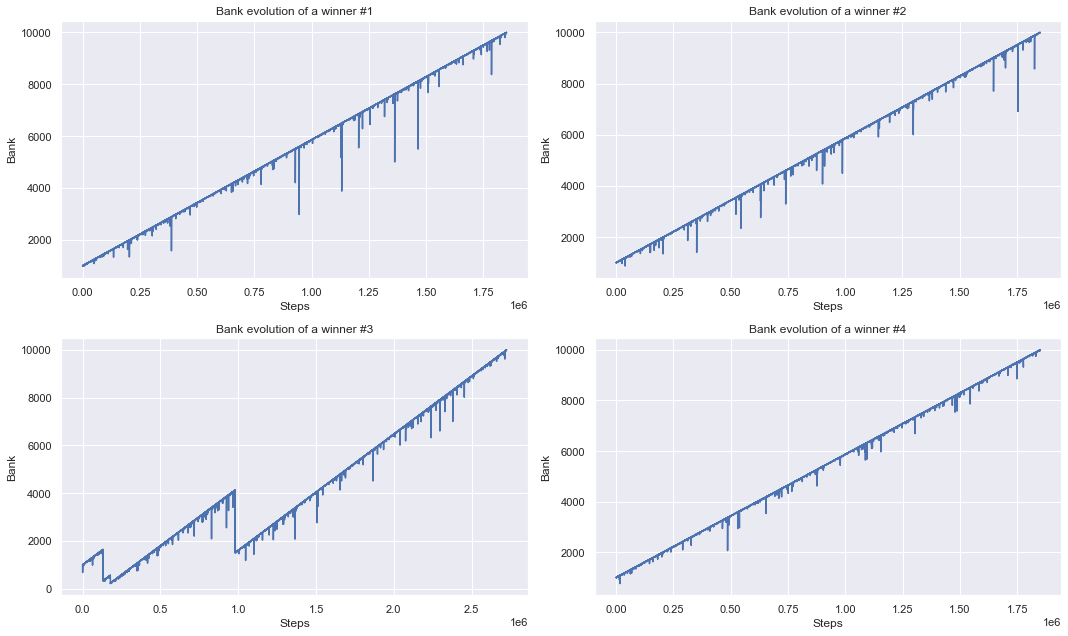

In [9]:
plot_bank_over_time(wbanks, lbanks, player_type='winner')

In the plots above, the x-axis represents the steps of a particular simulation and it's scaled in millions (notice "1e6" at the bottom right of each subplot). This means that the winners had to place millions of bets in order to achieve their 10x goal. Obviously, this is unachievable in real life, but as we have already said, we will ignore such inconvenient constraints.

The y-axis represents the bank value of step x. It goes up to 10k because the player stops playing after reaching the goal.

Even with such a small initial bet (0.01), some of these players had to bet more than £2,000 at some point after a long streak of losses. But fortunately for them, they didn't lose their entire bank, and they ended up winning. But some other players were less lucky and lost all their money... Let's take a look at 4 examples of the progression of the losers' bank.

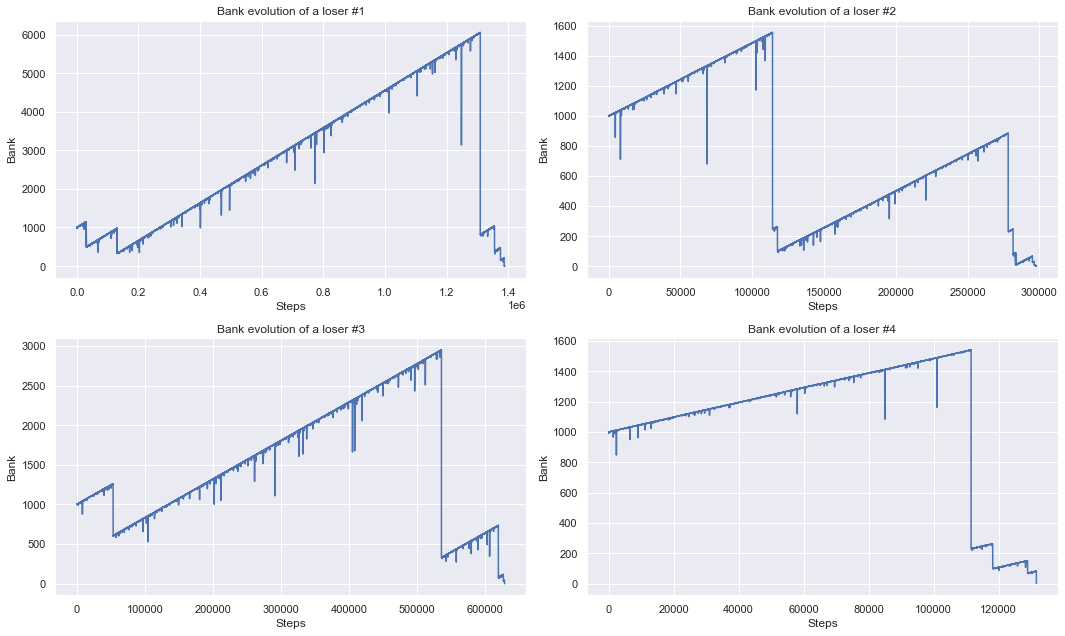

In [10]:
plot_bank_over_time(wbanks, lbanks, player_type='loser')

Even though the probability of losing, for example, 15 times in a row is extremely low (0.002%), as you need to play millions of games in order to win, eventually most people end up losing everything because of a lose streak.

The Martingale strategy was much harsher on these players, especially the first one who went from £1,000 to £6,000, but then lost everything. 

It may seem very unlikely to make the wrong choice 15 times in a row, especially when the probability of correctly choosing the right colour is almost a coin flip (48,65%). The probability of 15 losses in a row during a sequence of bets is only 0.002%, but you will have to play millions of sequences in order to win enough money for your 10x goal. So with enough time, it is very likely that a long losestreak will happen at some point, but this is something that gamblers don't take into account when playing with these kinds of strategies.

Optionally, you can take a look at all 10k simulations' stats:

In [11]:
df = pd.concat([pd.Series(steps), pd.Series(max_banks), pd.Series(max_bets)], axis=1)
df.columns = ['Steps', 'Max Bank', 'Max Bet']
df.describe()

,Steps,Max Bank,Max Bet
count,10000,10000,10000
mean,348422,1897,641
std,445238,1422,465
min,5417,1000,328
25%,99288,1147,328
50%,200354,1395,655
75%,403474,2011,655
max,5433584,10000,2621


The biggest bet someone placed was £2621, meaning that the unluckiest person lost 18 times in a row. This can be verified with geometric series:

$$ a_n=0.01*2^n-1 $$

The probability of losing 18 times in a row is about 0.00023%. This poor person will probably never play roulette again.

**(!) BUT, our goal was probably too ridiculous. Making 10x of your initial bank isn't realistic. What about making 2x?**

## Scenario 2: 1 million simulations with a 2x goal (+ bet size = £1)

Let's try to simulate 100k games with inital bank of £1,000 and the goal of £2,000. Just a 2x, a much less optimistic goal than a 10x.

We will also increase our initial bet size to 1 pound. The idea is that although this time the bet size will escalate faster, the number of steps needed to reach the goal will be smaller, so maybe we will be lucky enough to double the pot before the unlucky losing streak occurs.

In [12]:
start = time.time()
steps, max_banks, max_bets, wbanks, lbanks, winners = simulate_numba(simulations=1000000, bet=1, bank=1000, goal=2000)
end = time.time()

print(f"Execution time: {int(end-start)} s.")

Execution time: 284 s.


Note that even though we increased the number of simulations to 1 million, the code ran faster than in scenario 1 with 10k simulations because the average number of steps per simulation decreased. This is the effect of the higher bet size (games finish faster).

#### Scenario 2: results & stats

In [13]:
print(f"Total number of games played: {len(steps)}")
print(f"Steps on average: {int(np.mean(steps))}")
print(f"Max Bets on average: {int(np.mean(max_bets))}")
print(f"Max Banks on average: {int(np.mean(max_banks))}\n")
print(f"Number of Winners: {winners}")
print(f"% of Winners: {winners / len(steps) * 100:.1f}%")

Total number of games played: 1000000
Steps on average: 2261
Max Bets on average: 480
Max Banks on average: 1590

Number of Winners: 344977
% of Winners: 34.5%


Well, it looks like even with a 2x goal the odds of winning aren't that great: only 35% of players doubled their initial bank, all the others lost everything.

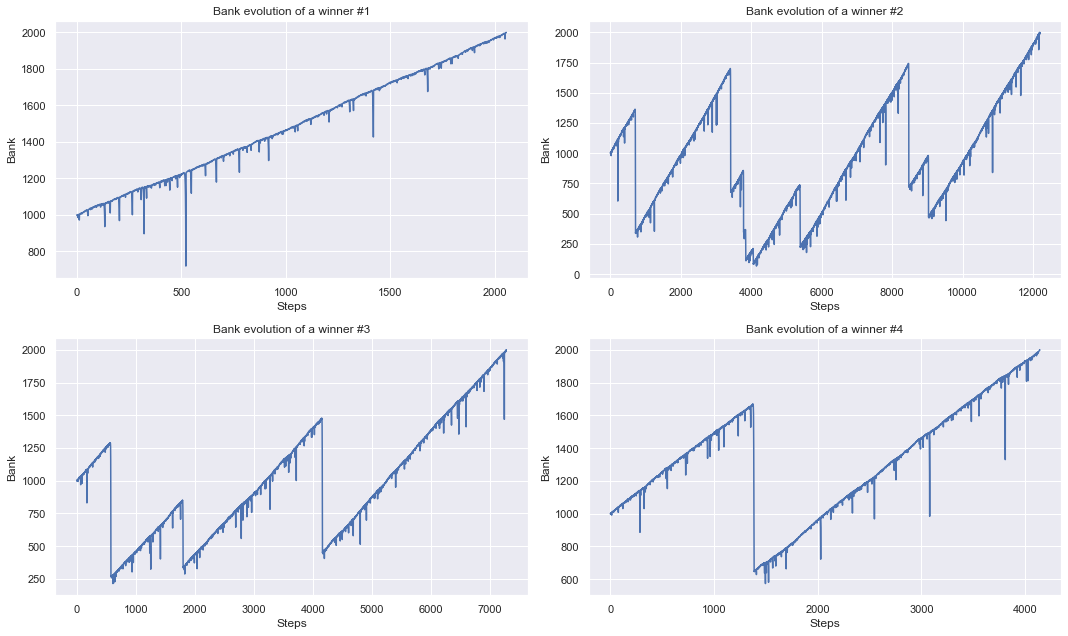

In [14]:
plot_bank_over_time(wbanks, lbanks, player_type='winner')

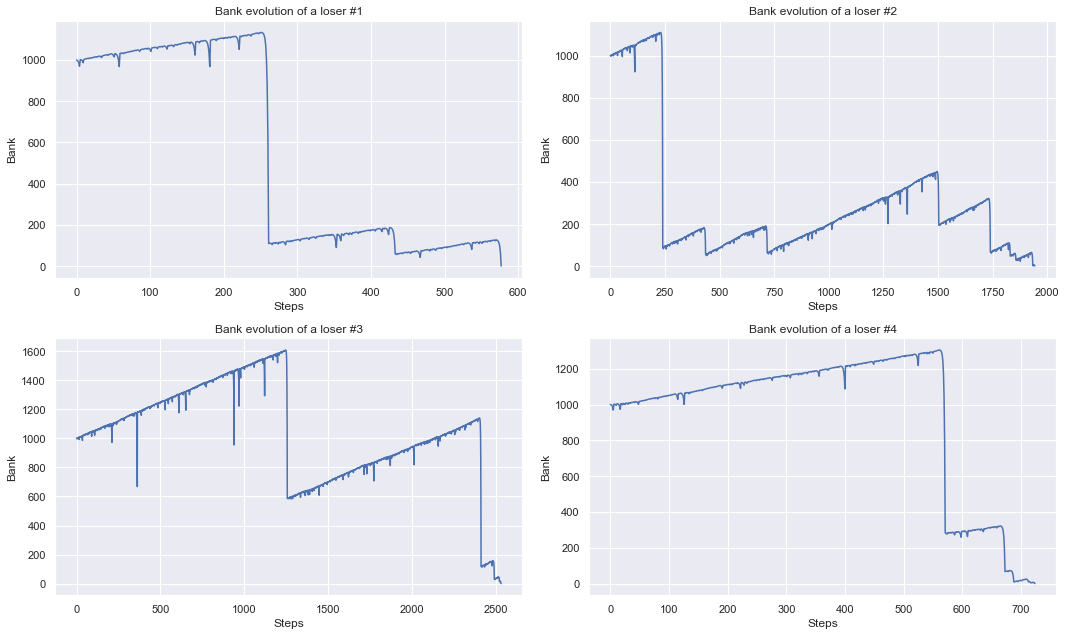

In [15]:
plot_bank_over_time(wbanks, lbanks, player_type='loser')

In [16]:
df = pd.concat([pd.Series(steps), pd.Series(max_banks), pd.Series(max_bets)], axis=1)
df.columns = ['Steps', 'Max Bank', 'Max Bet']
df.describe()

,Steps,Max Bank,Max Bet
count,1000000,1000000,1000000
mean,2261,1591,480
std,1675,372,87
min,39,1000,64
25%,1177,1226,512
50%,2031,1599,512
75%,2695,2000,512
max,23904,2000,512


## Conclusion

The Martingale strategy is a **TERRIBLE** gambling strategy. We confirmed this thanks to the Monte Carlo simulations, but it can also be confirmed mathematically (see the video mentioned at the beginning of the notebook).

In fact, we've seen that the probability of doubling your initial pot with this strategy is roughly 35%, so it's actually much better to just go all-in on red or black and double the pot with a 48.7% probability. 

The Martingale strategy deceives people into thinking that they are unlikely to lose the whole pot: the human brain can very easily underestimate exponential growth. In addition, [the Gambler's Fallacy](https://www.investopedia.com/terms/g/gamblersfallacy.asp) makes the situation even worse.

Long story short, the expected value of a roulette game is **negative for the player**, and no strategy can change that.

#### Bonus

As a bonus, let's check the performance gain with a very simple function: we'll call np.random.choice from NumPy many times, and we'll count how many times it rolled red, black, or zero. There doesn't seem to be much to optimize here, but even this function will benefit greatly from Numba. Again, we will have two functions with identical code (except for the Numba decorator): `check_random_outcomes` (imported) and `check_random_outcomes_numba` (that you'll find in the next cell).

In [17]:
@jit(nopython=True)
def check_random_outcomes_numba(outcomes: np.ndarray, nb: int = 100) -> Tuple[int, int, int]:
    """
    Selects a random outcome out of a numpy array a number of times. (!) Performance improved by Numba (notice the decorator).
    The numpy array contains string representations of all possible outcomes of a roulette wheel.
    Counts how many times red, black and zero were chosen with np.random.choice.
    Outcomes array will contain the following integers: 1 (red), 2 (black), 0 (zero).
    Strings ['red', 'black', 'zero'] can also be used in the array, but it is preferable to use numbers.
    
    Args:
        outcomes: numpy array that contains all outcomes. For European roulette: 18 red, 18 black, 1 zero.
        nb: (int) number of times a random choice will be made from "outcomes" array.
    
    Returns:
        A tuple with 3 ints: counts of red, black and zero outcomes.
    """
    assert list(np.sort(np.unique(outcomes))) == [0, 1, 2], \
        "Incorrect outcomes array, it should only contain the following outcomes: [0, 1, 2]"
    
    # Initialize the counts
    red_count = 0
    black_count = 0
    zero_count = 0
    
    for i in range(nb):
        # Spin the wheel, the outcome will be one of the following: [0, 1, 2]
        outcome = outcomes[np.random.choice(outcomes.shape[0], 1)[0]]
        
        # Update the count that corresponds to the observed outcome
        if outcome == 1:
            red_count += 1
        elif outcome == 2:
            black_count += 1
        else:
            zero_count += 1  # Guaranteed to be 0 because of assert above

    return red_count, black_count, zero_count

In [18]:
outcomes_roulette = np.array([1]*18 + [2]*18 + [0])  # 37 possible outcomes in a European roulette
nb_bets = 100000000  # Number of times we'll spin the wheel in "check_random_outcomes" function
            
start = time.time()
red_count, black_count, zero_count = check_random_outcomes(outcomes=outcomes_roulette, nb=nb_bets)
end = time.time()
print(f"Execution time (without Numba): {int(end-start)} s.")

start = time.time()
red_count, black_count, zero_count = check_random_outcomes_numba(outcomes=outcomes_roulette, nb=nb_bets)
end = time.time()
print(f"Execution time (with Numba): {int(end-start)} s.\n")
        
print("Red:   ", red_count, "  |   Prob: {}%".format(round(red_count / nb_bets * 100, 1)))
print("Black: ", black_count, "  |   Prob: {}%".format(round(black_count / nb_bets * 100, 1)))
print("Zero:  ", zero_count, "   |   Prob: {}%".format(round(zero_count / nb_bets * 100, 1)))

Execution time (without Numba): 1538 s.
Execution time (with Numba): 14 s.

Red:    48652938   |   Prob: 48.7%
Black:  48646030   |   Prob: 48.6%
Zero:   2701032    |   Prob: 2.7%


We have successfully observed 100 million random outcomes in roulette both with and without Numba. Again, there is a very significant performance boost when using Numba. In addition, the frequencies of red, black, and zero outcomes match the probabilities mentioned at the start of the notebook.